In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [13]:
df = pd.read_csv('clean.csv',parse_dates=['date'])
df.head()

,Unnamed: 0,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name
0,0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01,ahmadnagar
1,1,ahmednagar,bajri,2016,april,106.0,1788.0,1925.0,1875.0,2016-04-01,ahmadnagar
2,2,ahmednagar,wheat(husked),2015,april,1253.0,1572.0,1890.0,1731.0,2015-04-01,ahmadnagar
3,3,ahmednagar,wheat(husked),2016,april,387.0,1750.0,2220.0,1999.0,2016-04-01,ahmadnagar
4,4,ahmednagar,sorgum(jawar),2015,april,3825.0,1600.0,2200.0,1900.0,2015-04-01,ahmadnagar


In [14]:
df.drop(['Unnamed: 0','district_name'],axis=1,inplace=True)
df.head()


,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date
0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01
1,ahmednagar,bajri,2016,april,106.0,1788.0,1925.0,1875.0,2016-04-01
2,ahmednagar,wheat(husked),2015,april,1253.0,1572.0,1890.0,1731.0,2015-04-01
3,ahmednagar,wheat(husked),2016,april,387.0,1750.0,2220.0,1999.0,2016-04-01
4,ahmednagar,sorgum(jawar),2015,april,3825.0,1600.0,2200.0,1900.0,2015-04-01


In [15]:
trendline = pd.pivot_table(df,index='Commodity',columns=['date'],aggfunc='mean')

In [22]:
trendline['modal_price'].head()

date,2014-09-01 00:00:00,2014-10-01 00:00:00,2014-11-01 00:00:00,2014-12-01 00:00:00,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,...,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00
Commodity,,,,,,,,,,,,,,,,,,,,,
amba koy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1500.000000,3750.0,4750.000000,NaN,NaN,NaN,NaN
ambat chuka,0.000000,136.000000,167.000000,270.000000,0.0,0.0,0.0,196.0,0.0,1350.0,...,0.000000,NaN,193.000000,0.000000,500.0,325.500000,919.25,665.500000,748.000000,1251.0
amla,1400.000000,1777.000000,1580.000000,1634.000000,1637.5,1800.0,1800.0,NaN,NaN,NaN,...,1275.000000,NaN,NaN,NaN,NaN,NaN,NaN,2500.000000,1700.000000,1500.0
apple,6342.666667,5922.571429,6042.833333,5164.833333,5544.0,5137.0,6233.6,8497.0,10089.0,10161.0,...,6312.333333,8293.6,9961.444444,8427.181818,10037.2,8936.181818,7276.00,7290.461538,6615.083333,6905.6
arvi,2520.500000,2397.500000,2521.000000,2266.500000,2800.0,2622.5,2313.5,2405.5,2149.0,2207.5,...,1885.000000,2135.0,2371.500000,2484.333333,2434.5,2425.000000,2267.00,2043.000000,2006.500000,2010.5


###  Example to use the trendline pivot table to get monthly trendline for any commodity
trendline['feature_name'].loc['commodity_name'].plot()

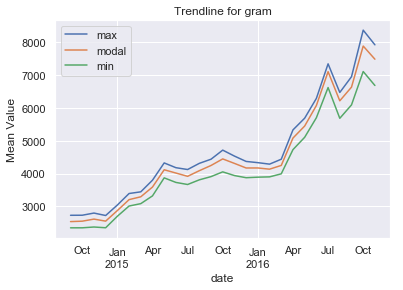

In [21]:
trendline['max_price'].loc['gram'].plot()
trendline['modal_price'].loc['gram'].plot()
trendline['min_price'].loc['gram'].plot()
plt.title('Trendline for gram')
plt.ylabel('Mean Value')
plt.legend(['max','modal','min'])